# **Solve 12-Node MaxCut with QAOA**

A little bit of setup...

In [ ]:
%%capture
!pip install qiskit
!pip install pylatexenc

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

**Create Random Graph**


Create a random Erdos-Renyi Graph with *nqubits* nodes and a probability *p* of each node forming an edge with another node.

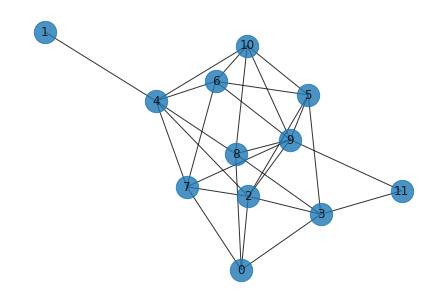

In [ ]:
#Draw graph
nqubits = 12
G = nx.fast_gnp_random_graph(nqubits, p=0.4)
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

**Implement algorithm**

`max_cut` describes our objective function: (-1)×(number of shared edges in the partition *x* of graph *G*). `compute_expectation(counts, G)` finds the average number of shared edges among the graph partitions measured by our simulator ***multiplied by -1**. Our aim is to use an optimizer (see 'Optimization' section) to minimize this expectation value, as the most negative expectation corresponds to greatest likelihood of measuring a partition with the maximum number of shared edges. `create_qaoa_circ(G, theta)` builds a circuit that implements a maxcut QAOA for a graph G with parameters theta, which are provided by the optimizer. `get_expectation(G, shots)` runs our circuit *shots* number of times and returns the expectation value of all the outcomes

In [ ]:
def maxcut_obj(x, G):
  """ Given a solution bitstring x, return the (negative) number of edges
  between the two partitions. """
  obj = 0
  for i,j in G.edges():
    if x[i] != x[j]: obj -=1
  return obj

def create_qaoa_circ(G, theta):
  """ Builds the parametrized circuit for QAOA"""
  nqubits = len(G.nodes())
  p = len(theta)//2 #number of alternatig unitary pairs
  qc = QuantumCircuit(nqubits)
  #values for parameters
  beta = theta[:p]
  gamma = theta[p:]
  #initialize state as superposition
  for i in range(nqubits): qc.h(i)
  #iterate through parameters
  for beta, gamma in zip(beta, gamma):
    # problem unitary
    for pair in list(G.edges()):
      qc.rzz(2*gamma, pair[0], pair[1])
    # mixer unitary
    for i in range(nqubits):
      qc.rx(2*beta, i) #try list compression
    
    qc.measure_all()
    return qc

def compute_expectation(counts, G):
  """ Computes the expectation value based on measurement results.
      counts: a dict with the solution bitstring as key, and the measurement count as val """
  avg = 0; sum_count = 0
  for solution, count in counts.items():
    obj = maxcut_obj(solution, G)
    avg += obj * count
    sum_count += count
  return avg/sum_count

def get_expectation(G, shots=1000):
  """ set up simulator and run our circuit nshots number of times. The beta and gamma parameters 
  held in theta are initialized by the optimizer (in next cell)"""
  #set up simulator
  backend = Aer.get_backend('qasm_simulator')

  def execute_circ(theta):
      
    qc = create_qaoa_circ(G, theta)
    counts = backend.run(qc, seed_simulator=10, 
                          nshots=shots).result().get_counts()  
    return compute_expectation(counts, G)
  return execute_circ

**Optimize**\
We minimize our expectation by updating our parameters *theta* with the COBYLA solver. The array 'theta' provides our initial parameters.

In [ ]:
from scipy.optimize import minimize
""" minimize our expectation by allowing our optimizer to update our beta and gamma
parameters stored in the array theta. Recall that our expectation is -1*(average number of shared edges of measured solution), 
so minimizing it yields a value representative of the maximium number of shared edges""" 
theta = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expectation = get_expectation(G)
res = minimize(expectation, 
                      theta, 
                      method='COBYLA')
res

     fun: -15.1201171875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 75
  status: 1
 success: True
       x: array([2.92448599, 1.01034976, 1.00863254, 0.16083989, 1.00861197,
       0.93529363])

# Our Solution

We run our QAOA circuit using the optimal set of parameters (beta and gamma stored in the array theta) and print a histogram of the measurements. We find the the most probable partition, which is our maxcut solution, and display the partitioned graph in bitartite form below, with colors corresponding to each group. 

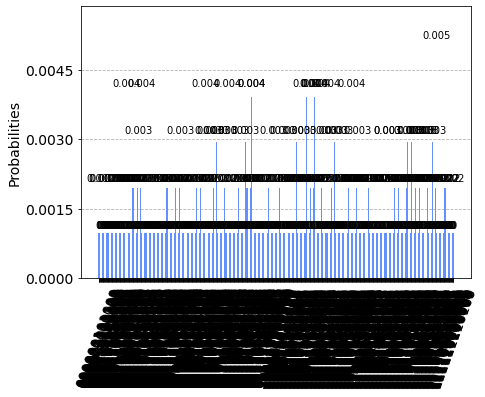

In [ ]:
from qiskit.visualization import plot_histogram
""" Take our solution parameters, stored in res.x, and run our qaoa circuit on them to see 
the most probable outcomes, which should correspond to max partitions"""
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)

Bitstring solution:  101011100011
Shared Edges in Max Cut:  17


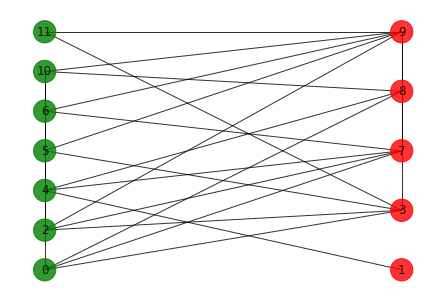

In [ ]:
""" Find the solution with the greatest measurement probability (this is our max_cut solution), 
and print out the number of shared edges of this solution and the solution graph in bipartite form"""

#Search for item with most counts
max_count = 0
solution=''
for x, count in counts.items():
  if count > max_count:
    solution = x

#find the number of edges for the partition
print('Bitstring solution: ', solution)
print('Shared Edges in Max Cut: ', -maxcut_obj(solution, G))
#draw solution graph
colors = ['red', 'green']
color_list = [colors[int(group)] for group in solution]
node_set = [idx for idx, group in enumerate(solution) if group=='1']
nx.draw(G, pos=nx.bipartite_layout(G, node_set), with_labels=True, alpha=0.8, node_size=500, node_color=color_list)